In [259]:
import numpy as np
import pandas as pd
import time
import pickle


from joblib import dump, load
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer

pd.options.display.float_format = '{:20,.15f}'.format
pd.options.display.max_columns = None

In [260]:
from importlib import reload
# module references for reload
import process_df, output, run_models

from process_df import Process, create_average_columns, split_process_df, split_df
from output import output_metrics, mape, smape, get_metrics, print_sorted_actual_to_predicted_graphs_only_test
from run_models import run_nn, run_lgb, run_rf, build_nn_model

reload(process_df)
reload(output)
reload(run_models)

# reimport in case changed
from process_df import Process, create_average_columns, split_process_df, split_df
from output import output_metrics, mape, smape, get_metrics, print_sorted_actual_to_predicted_graphs_only_test
from run_models import run_nn, run_lgb, run_rf, build_nn_model

In [261]:
def get_df_work_columns(df):
    return df[[col for col in df_full.columns if not 'META' in col or col == 'META__revenue']]

In [262]:
df_full_name = 'outliers/df_full_dropped.csv'

df_full = pd.read_csv(df_full_name, index_col='id')
df_raw = pd.read_csv('outliers/df_raw_dropped.csv', index_col='id')

with open(f'{df_full_name}_raw_data.pickle', 'rb') as handle:
    data_raw = pickle.load(handle)
X_raw = pd.concat([data_raw['X_train'], data_raw['X_test'], data_raw['X_val']])
y_raw = pd.concat([data_raw['y_train'], data_raw['y_test'], data_raw['y_val']])

with open(f'{df_full_name}_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
X = pd.concat([data['X_train'], data['X_test'], data['X_val']])
y = np.concatenate([data['y_train'], data['y_test'], data['y_val']])
    
with open(f'{df_full_name}_process.pickle', 'rb') as handle:
    process = pickle.load(handle)

In [263]:
def get_profitable(key):
    df = df_raw.loc[list(data[key].index)]
    return df['META__revenue'] > df['budget']

In [264]:
y_train, y_test, y_val = get_profitable('X_train'), get_profitable('X_test'), get_profitable('X_val')

In [265]:
X_train, X_test, X_val = data['X_train'], data['X_test'], data['X_val']

In [266]:
import tensorflow as tf

In [267]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [268]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l1_l2


In [269]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
tf.autograph.set_verbosity(1)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)
session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [392]:
def create_baseline():
    adamax = Adamax(learning_rate=0.001,beta_1=0.958,beta_2=0.987)
    model = Sequential([
    # Dense(
    #     64, 
    #     activation='sigmoid', 
    #     input_shape=[228],
    #     kernel_initializer='glorot_normal',
    #     kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001),
    #     bias_regularizer=l1_l2(l1=0.001, l2=0.1)
    # ),
    # Dropout(0.5),
    Dense(
        64, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l1_l2(l1=0.05, l2=0.05),
        bias_regularizer=l1_l2(l1=0.05, l2=0.05),
    ),
    Dropout(0.5),  
    Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='sigmoid'
    )
    ])

    model.compile(loss='binary_crossentropy',
                optimizer=adamax,
                metrics=['accuracy'])
    return model

In [393]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

In [394]:
class_weights

{0: 1.561744613767735, 1: 0.7354615194258847}

In [395]:
estimator = KerasClassifier(build_fn=create_baseline, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
es = EarlyStopping(verbose=1, patience=10000)

In [396]:
history = estimator.fit(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=30000, 
    batch_size=256, 
    verbose=0, 
    callbacks=[es], 
    # class_weight=class_weights,
)


Epoch 01074: early stopping


In [397]:
e = estimator.predict(X_test)
print(sum(e)[0], sum(y_test))

662 503


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
val accuracy 0.7317073345184326


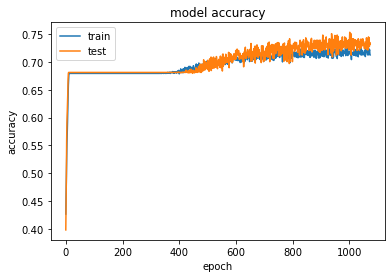

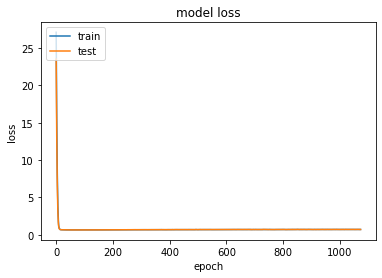

In [398]:
import matplotlib.pyplot as plt
print(history.history.keys())
print('val accuracy', history.history['val_accuracy'][-1:][0])
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
val accuracy 0.7392767071723938


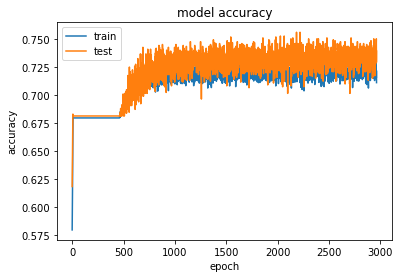

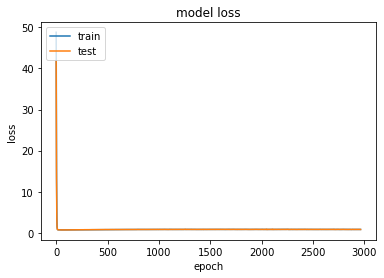

In [364]:
import matplotlib.pyplot as plt
print(history.history.keys())
print('val accuracy', history.history['val_accuracy'][-1:][0])
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

0.6837146878242493

In [157]:

results = cross_validate(estimator, Xx.values, yy, cv=kfold, verbose=1, error_score='raise', scoring=['accuracy', 'precision', 'recall'],
    fit_params={'epochs': 10000, 'validation_split': 0.1, 'batch_size': 256, 'shuffle': True, 'callbacks': [es]})
results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Epoch 00090: early stopping
Epoch 00093: early stopping
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s finished


{'fit_time': array([3.52425575, 3.63053608]),
 'score_time': array([0.06154251, 0.05780244]),
 'test_accuracy': array([0.67886945, 0.67886945]),
 'test_precision': array([0.67886945, 0.67886945]),
 'test_recall': array([1., 1.])}

In [155]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']